In [1]:
#Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install datasets
!pip install evaluate
!pip install scikit-learn
!pip install transformers
#!pip install peft
!pip install wandb
!pip install emoji
!pip install accelerate
!pip install -U bitsandbytes peft
!pip install focal-loss-torch


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 11.4 MB/s eta 0:00:00
 

In [12]:


import pandas as pd
import numpy as np
import torch
import os
from torch.nn import Module  # Import Module from torch.nn
from torch import nn
import inspect
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, DataCollatorWithPadding, BitsAndBytesConfig, AutoConfig, AutoModel
from peft import LoraConfig, TaskType, get_peft_model, prepare_model_for_kbit_training
from datasets import Dataset, DatasetDict
from evaluate import load as load_metric
import wandb
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import multilabel_confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from torch.utils.data import DataLoader
import emoji
import re  # For regular expressions
from huggingface_hub import login
import gc
from sklearn.utils import resample
import time
from accelerate import infer_auto_device_map, dispatch_model
from pathlib import Path
from torch.nn import BCEWithLogitsLoss

In [4]:
# Replace 'your_hf_token' with the token you generated
login(token="XXXX")

In [5]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Set file paths
train_path = '/content/drive/MyDrive/data/datasets/cleaned_train.csv'
test_path = '/content/drive/MyDrive/data/datasets/cleaned_test.csv'

# Load the data
df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)

In [7]:
# Configuration
MODEL_NAME = "BAAI/bge-base-en-v1.5"
MAX_LENGTH = 256
BATCH_SIZE = 32
LEARNING_RATE = 1e-5
NUM_EPOCHS = 5
LORA_R = 32
LORA_ALPHA = 64
LORA_DROPOUT = 0.05

labels_emo = ['anger', 'anticipation', 'disgust', 'fear', 'joy',
                  'love', 'optimism', 'pessimism', 'sadness', 'surprise', 'trust']



original class distribution

Class Distribution:
anger        - Positive:  5602 ( 25.9%)
              Negative: 16044 ( 74.1%)
anticipation - Positive:  5351 ( 24.7%)
              Negative: 16295 ( 75.3%)
disgust      - Positive:  6008 ( 27.8%)
              Negative: 15638 ( 72.2%)
fear         - Positive:  4582 ( 21.2%)
              Negative: 17064 ( 78.8%)
joy          - Positive:  9546 ( 44.1%)
              Negative: 12100 ( 55.9%)
love         - Positive:  4082 ( 18.9%)
              Negative: 17564 ( 81.1%)
optimism     - Positive:  8180 ( 37.8%)
              Negative: 13466 ( 62.2%)
pessimism    - Positive:  3745 ( 17.3%)
              Negative: 17901 ( 82.7%)
sadness      - Positive:  6009 ( 27.8%)
              Negative: 15637 ( 72.2%)
surprise     - Positive:  3546 ( 16.4%)
              Negative: 18100 ( 83.6%)
trust        - Positive:  3688 ( 17.0%)
              Negative: 17958 ( 83.0%)


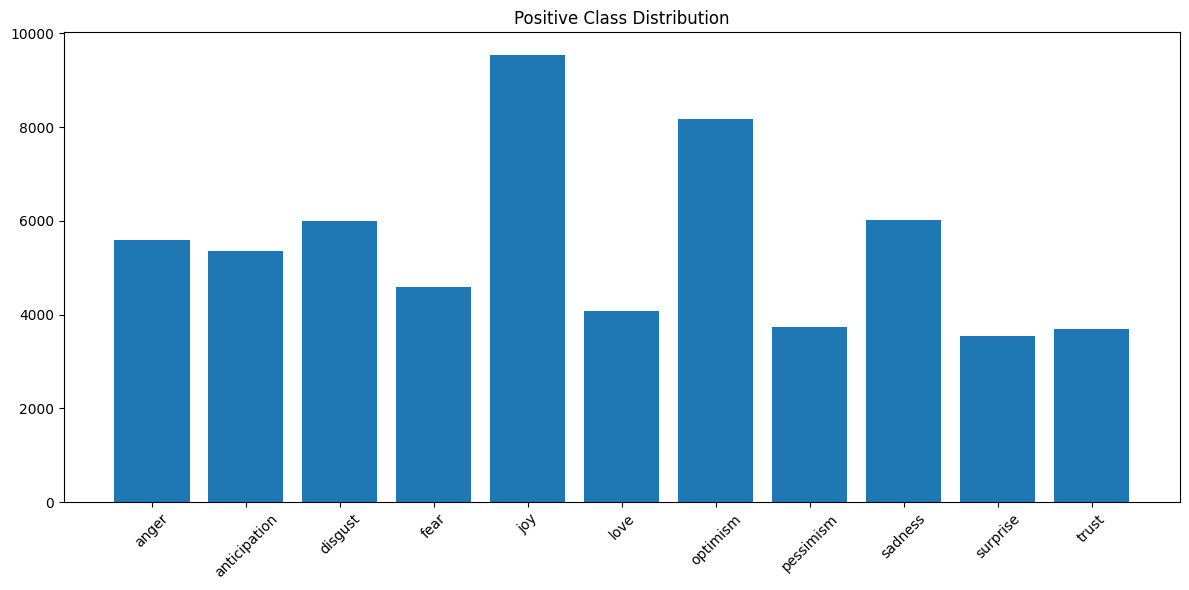

In [9]:
def class_distribution(df, labels_emo):
    print("\nClass Distribution:")
    for col in labels_emo:
        pos = df[col].sum()
        total = len(df)
        print(f"{col:12} - Positive: {pos:5d} ({pos/total*100:5.1f}%)")
        print(f"{' '*12}  Negative: {total-pos:5d} ({(total-pos)/total*100:5.1f}%)")

    plt.figure(figsize=(12, 6))
    pos_counts = [df[col].sum() for col in labels_emo]
    plt.bar(labels_emo, pos_counts)
    plt.title('Positive Class Distribution')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Clean Data
data = df_train
data[labels_emo] = (data[labels_emo] > 0).astype(int)

# original distribution
print("\noriginal class distribution")
class_distribution(data, labels_emo)

# Create train/eval split
train_df = data.sample(frac=0.8, random_state=42)
eval_df = data.drop(train_df.index)

In [10]:
class EmotionClassifier(nn.Module):
    def __init__(self, model_name, num_labels):
        super().__init__()
        self.num_labels = num_labels

        class_weights = []
        for col in labels_emo:
            pos_count = train_df[col].sum()
            total = len(train_df)
            weight = total / (2 * pos_count)
            class_weights.append(weight)

        self.class_weights = torch.tensor(class_weights, dtype=torch.float32)

        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            problem_type="multi_label_classification"
        )

        self.model = prepare_model_for_kbit_training(self.model)
        self.model.gradient_checkpointing_enable()

        lora_config = LoraConfig(
            r=LORA_R,
            lora_alpha=LORA_ALPHA,
            target_modules=["query", "key", "value"],
            lora_dropout=LORA_DROPOUT,
            bias="none",
            task_type="SEQ_CLS"
        )

        self.model = get_peft_model(self.model, lora_config)
        self.loss_fct = BCEWithLogitsLoss(pos_weight=self.class_weights)

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        if labels is not None:
            labels = labels.to(device=outputs.logits.device, dtype=torch.float32)
            self.class_weights = self.class_weights.to(outputs.logits.device)
            loss = self.loss_fct(outputs.logits, labels)
            return {"loss": loss, "logits": outputs.logits}
        return {"logits": outputs.logits}

    def gradient_checkpointing_enable(self, **kwargs):
        self.model.gradient_checkpointing_enable()

In [13]:

print("\nInitialize")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
model = EmotionClassifier(MODEL_NAME, len(labels_emo))

# Tokenize and format data
def tokenize(examples):
    tokenized = tokenizer(
        examples['Tweet'],
        padding='max_length',
        truncation=True,
        max_length=MAX_LENGTH,
        return_tensors=None
    )

    if all(col in examples for col in labels_emo):
        labels = np.array([examples[col] for col in labels_emo], dtype=np.float32).T
        tokenized['labels'] = labels

    return tokenized

# Create datasets
train_dataset = Dataset.from_pandas(train_df[['Tweet'] + labels_emo])
eval_dataset = Dataset.from_pandas(eval_df[['Tweet'] + labels_emo])

train_dataset = train_dataset.map(
    tokenize,
    batched=True,
    remove_columns=train_dataset.column_names
)

eval_dataset = eval_dataset.map(
    tokenize,
    batched=True,
    remove_columns=eval_dataset.column_names
)

train_dataset.set_format(type='torch')
eval_dataset.set_format(type='torch')


Initialize


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at BAAI/bge-base-en-v1.5 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/17317 [00:00<?, ? examples/s]

Map:   0%|          | 0/4329 [00:00<?, ? examples/s]

In [14]:
# Compute metrics
def compute_metrics(pred):
    logits = pred.predictions
    labels = pred.label_ids
    predictions = (torch.sigmoid(torch.tensor(logits)) > 0.5).numpy()

    f1_macro = f1_score(labels, predictions, average='macro')
    accuracy = accuracy_score(labels.flatten(), predictions.flatten())

    return {
        'f1_macro': f1_macro,
        'accuracy': accuracy
    }

In [15]:
from transformers import DataCollatorWithPadding

# Training arguments
training_args = TrainingArguments(
    output_dir="/content/mteb_emotion",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=NUM_EPOCHS,
    weight_decay=0.01,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="f1_macro",
    greater_is_better=True,
    gradient_checkpointing=True,  # Keep this
    gradient_accumulation_steps=4,
    warmup_ratio=0.1,
    logging_steps=10,
    fp16=True
)

# Define custom data collator
class MultiLabelDataCollator(DataCollatorWithPadding):
    def __call__(self, features):
        batch = super().__call__(features)
        if "labels" in batch:
            labels = torch.stack([torch.tensor(f["labels"]) for f in features])
            batch["labels"] = labels.float()
        return batch

# Initialize trainer with custom collator
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    data_collator=MultiLabelDataCollator(tokenizer=tokenizer)
)

# Train model
print("\ntraining")
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.



training


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<ipython-input-15-db7b4ecb33fd>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.stack([torch.tensor(f["labels"]) for f in features])


Epoch,Training Loss,Validation Loss,F1 Macro,Accuracy
0,0.856300,0.849035,0.184502,0.634201
1,0.827500,0.825468,0.101807,0.763939
2,0.812000,0.796007,0.156141,0.779164
3,0.779100,0.767024,0.270732,0.782461
4,0.763200,0.759145,0.316811,0.780025


<ipython-input-15-db7b4ecb33fd>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.stack([torch.tensor(f["labels"]) for f in features])
<ipython-input-15-db7b4ecb33fd>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.stack([torch.tensor(f["labels"]) for f in features])
<ipython-input-15-db7b4ecb33fd>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  labels = torch.stack([torch.tensor(f["labels"]) for f in features])
<ipython-input-15-db7b4ecb33fd>:28: UserWarning: To copy construct from a tensor, it is recomm

TrainOutput(global_step=675, training_loss=0.8182341533237033, metrics={'train_runtime': 294.4627, 'train_samples_per_second': 294.044, 'train_steps_per_second': 2.292, 'total_flos': 0.0, 'train_loss': 0.8182341533237033, 'epoch': 4.988929889298893})

In [16]:
test_data = df_test

# Create test dataset only with Tweet column
test_dataset = Dataset.from_pandas(test_data[['Tweet']])

# Apply same tokenization as training data
test_dataset = test_dataset.map(
    tokenize,
    batched=True,
    remove_columns=test_dataset.column_names
)
test_dataset.set_format("torch")

# Generate predictions
print("\nPredictions")
predictions = trainer.predict(test_dataset)
preds = (torch.sigmoid(torch.tensor(predictions.predictions)) > 0.5).int().numpy()

# Create submission DataFrame with proper format
submission = pd.DataFrame()
submission['ID'] = test_data['ID']  # Use original IDs from test data

# Initialize emotion columns with zeros
for col in labels_emo:
    submission[col] = 0

# Update with predictions where we have valid tweets
valid_mask = ~test_data['Tweet'].isna()
submission.loc[valid_mask, labels_emo] = preds[valid_mask]

# Ensure all columns are integers
for col in labels_emo:
    submission[col] = submission[col].astype(int)

# Verify format

print("Submission shape:", submission.shape)


# Save submission
submission.to_csv('MTEB_1.csv', index=False)
print("File saved as MTEB_1.csv")


Map:   0%|          | 0/3259 [00:00<?, ? examples/s]


Predictions


Submission shape: (3259, 12)
File saved as MTEB_1.csv
